In [1]:
import torch
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

from constants import LATENT_DIM, BATCH_SIZE, NUMBER_OF_PITCHES, LOWEST_PITCH, MUSIC_LENGTH, MUSIC_LENGTH, INFO_INTERVAL_STEPS, LPD_PATH, MAESTRO_PATH, LPD_FILE_EXTENSION, \
    MAESTRO_FILE_EXTENSION, NUM_EPOCHS

from utils import array_to_midi, get_device, show_learning_process, write_model_params_to_tensorboard, write_models_architecture_to_tensorboard, \
    write_losses_to_tensorboard, write_samples, save_models

from data_preparation import prepare_data

from train_eval import train_one_step, Metrics

from models import Generator, Discriminator, SequenceBarGenerator, TemporalVectors

## Get device

In [2]:
device = get_device()

cuda


## Prepare data

In [3]:
# pianoroll_idx -> maestro has index 0 and LPD has index 1 for piano data

# data_stacked = prepare_data(
#     file_path = MAESTRO_PATH,
#     file_extension=MAESTRO_FILE_EXTENSION,
#     length=MUSIC_LENGTH,
#     music_info_threshold = 0.04,
#     pianoroll_idx=0,
#     do_filtration=True
# )

In [4]:
# np.save(f'data/data_maestro_{192}_{0.04}.npy', data_stacked)

In [5]:
data_lpd = np.load(f'data/data_192_0.04.npy')

In [6]:
data_maestro = np.load(f'data/data_maestro_192_0.04.npy')

In [7]:
data_stacked = np.concatenate((data_lpd, data_maestro), axis=0)
data_stacked.shape

(38725, 192, 72)

In [8]:
training_data = torch.as_tensor(data_stacked, dtype=torch.float32)
dataset = torch.utils.data.TensorDataset(training_data)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

## Define models, optimizers etc.

In [9]:
# Create tensorboard writer instance
tensorboard_writer = SummaryWriter()

# Create models
vectors_model = TemporalVectors(latent_vector_size=LATENT_DIM, hidden_size=LATENT_DIM, num_layers=2, sequence_length=3, device=device)
bar_generator = Generator()
generator = SequenceBarGenerator(vectors_generator=vectors_model, bar_generator=bar_generator)
discriminator = Discriminator()

discriminator = discriminator.to(device)
generator = generator.to(device)

# Create optimizers
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.001,  betas=(0.5, 0.9))
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.001, betas=(0.5, 0.9))

# FOR ONE BAR
# sample_latent = torch.randn(8, LATENT_DIM, 1, 1).to(device)

# FOR SEQUENCE
sample_latent = torch.randn(1, 1, LATENT_DIM).to(device)

In [10]:
write_models_architecture_to_tensorboard(
    generator=generator,
    discriminator=discriminator,
    real_images_sample=training_data[0].reshape((1, 1, MUSIC_LENGTH, NUMBER_OF_PITCHES)).to(device),
    noise=torch.randn(1, 1, LATENT_DIM).to(device)
    )

## Train

In [11]:
training_evaluation = pd.DataFrame()
metrics = Metrics(bar_generator=generator, resolution=6, threshold=0.9, probe=50, device=device)

step = 0

history_samples = {}
discriminator_losses = []
generator_losses = []

generator.train()

for epoch in range(NUM_EPOCHS):
    for real_samples in data_loader:
        d_loss, g_loss = train_one_step(
            discriminator_optimizer=discriminator_optimizer,
            generator_optimizer=generator_optimizer,
            discriminator=discriminator,
            generator=generator,
            real_samples=real_samples[0].reshape(-1, 1, MUSIC_LENGTH, NUMBER_OF_PITCHES), 
            device=device
         )

        if step % INFO_INTERVAL_STEPS == 0:
            # Get generated samples
            print(f'EPOCH [{epoch}] | STEP [{step}] ---> Critic loss: {d_loss:.4f}  Generator loss: {g_loss:.4f}')
            generator.eval()
            samples = generator(sample_latent).cpu().detach().numpy()
            history_samples[step] = samples
            generator.train()
        step += 1

    d_loss = d_loss.detach().cpu()
    g_loss = g_loss.detach().cpu()
    discriminator_losses.append(d_loss)
    generator_losses.append(g_loss)

    write_model_params_to_tensorboard(tb_writer=tensorboard_writer, model=generator, epoch=epoch, prefix='generator_')
    write_model_params_to_tensorboard(tb_writer=tensorboard_writer, model=discriminator, epoch=epoch, prefix='discriminator_')

    write_losses_to_tensorboard(writer=tensorboard_writer, critic_loss=d_loss, generator_loss=g_loss, step=epoch)
    
    save_models(discriminator=discriminator, generator=generator, prefix=epoch)
    write_samples(generator=generator, device=device, name=f'{epoch}', threshold=0.5)

    next_epoch_metrics = metrics.create_metrics_df()
    training_evaluation = pd.concat([next_epoch_metrics, training_evaluation], ignore_index=True)
    training_evaluation.to_csv('metrics_eval.csv', index_label='epoch')

EPOCH [0] | STEP [0] ---> Critic loss: 0.9546  Generator loss: 0.3165
EPOCH [0] | STEP [1000] ---> Critic loss: -9.9616  Generator loss: 13.2634
EPOCH [1] | STEP [2000] ---> Critic loss: -8.0389  Generator loss: 5.2291
EPOCH [2] | STEP [3000] ---> Critic loss: -8.8997  Generator loss: 0.9142


## Quality evaluation

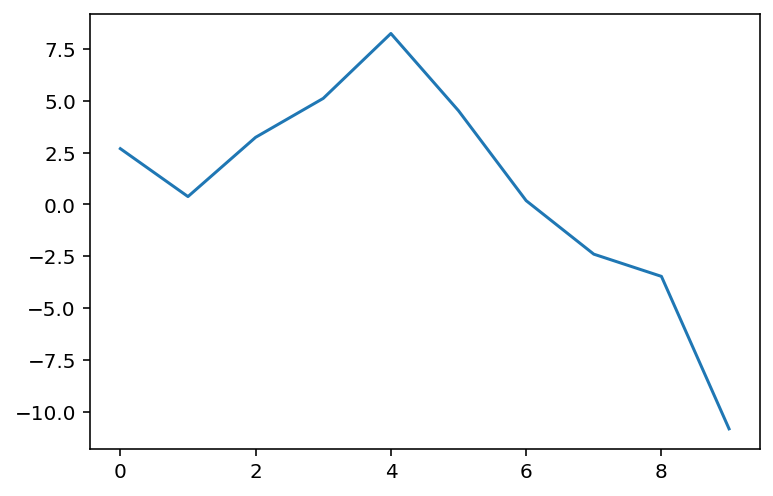

In [ ]:
plt.plot(range(len(generator_losses)), generator_losses)

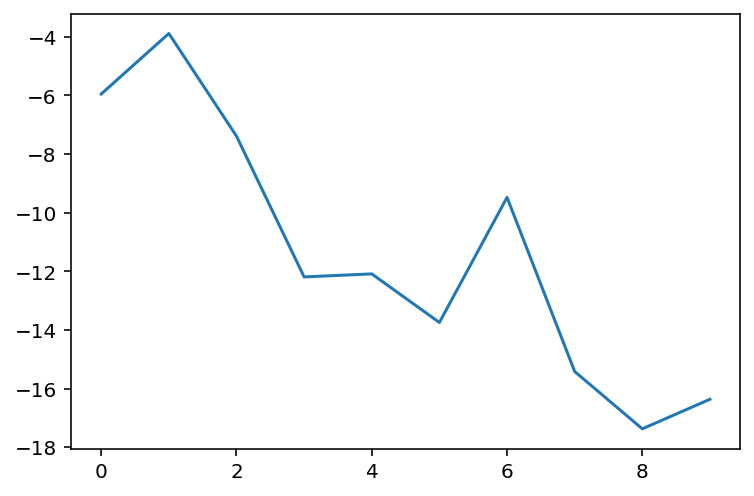

In [ ]:
plt.plot(range(len(discriminator_losses)), discriminator_losses)

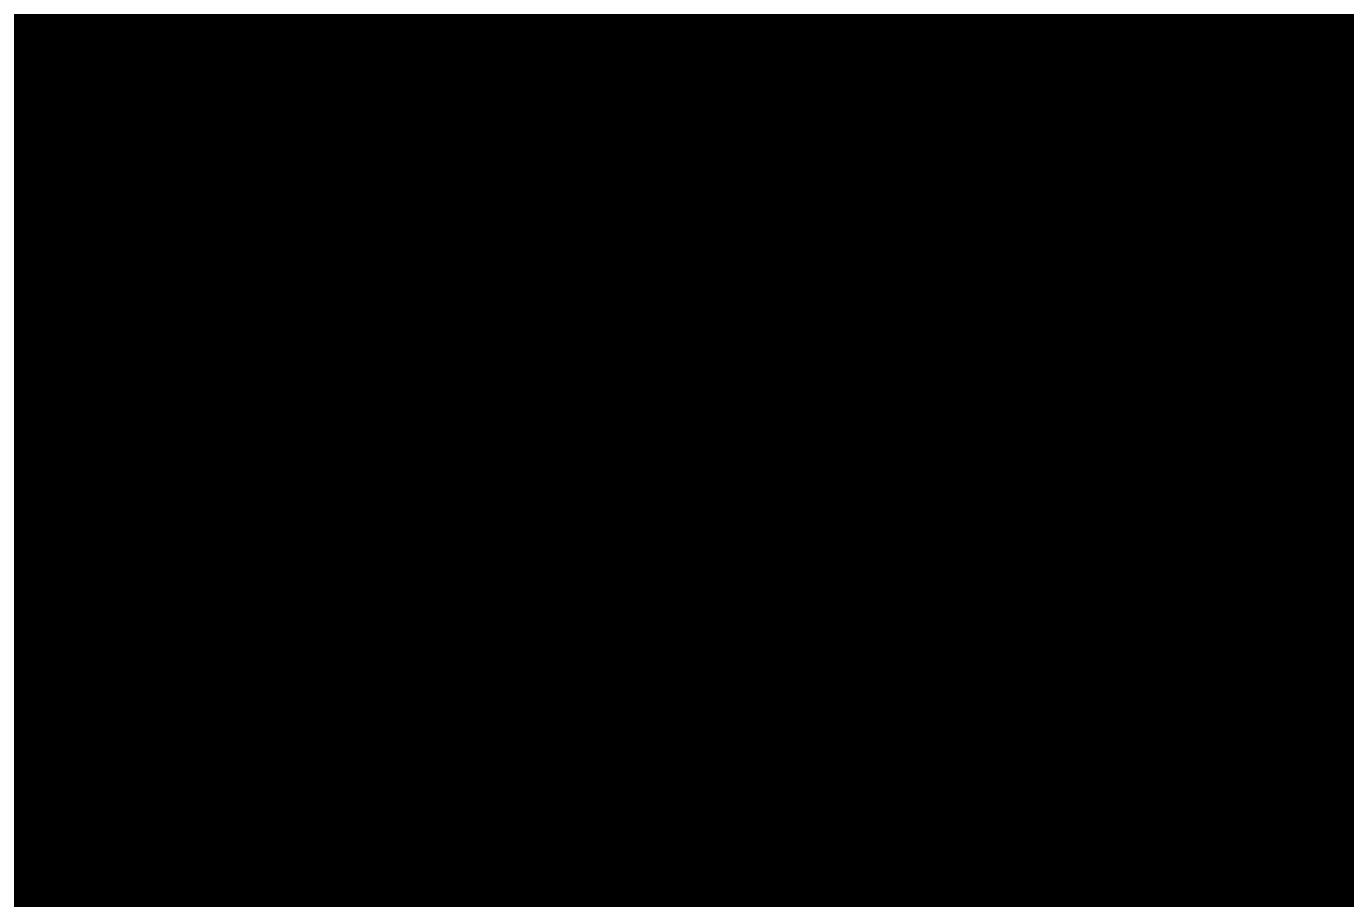

In [ ]:
show_learning_process(list(history_samples.values()))

Multitrack(name=None, resolution=6, tracks=[BinaryTrack(name=None, program=0, is_drum=False, pianoroll=array(shape=(192, 128), dtype=bool))])

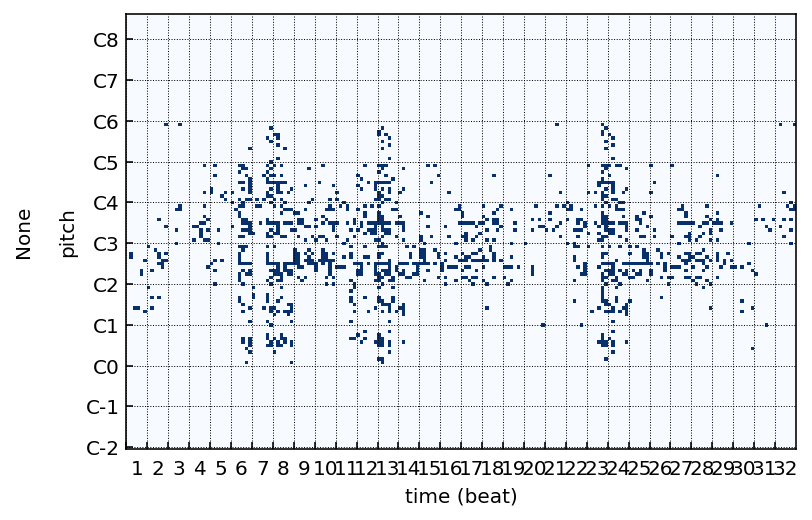

In [ ]:
metrics.bar_generator.vectors_generator.sequence_length=3
array_example = metrics.generate_random_midi_array()
array_to_midi(music_array=array_example, midi_path='test.midi', plot=True, resolution=6)

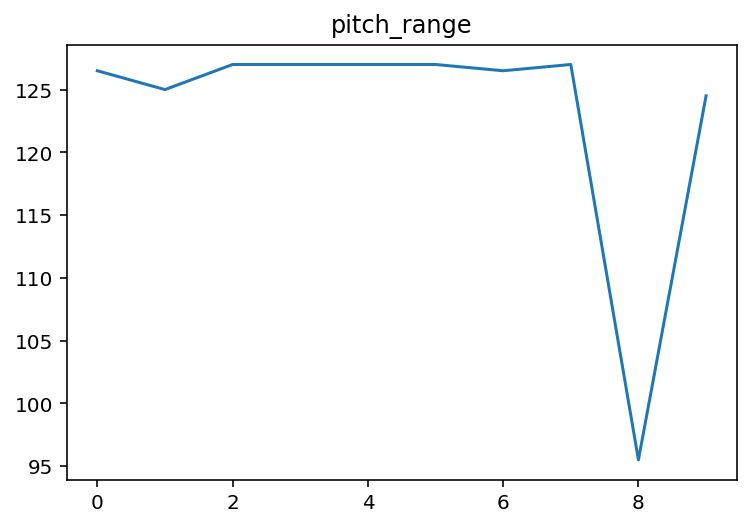

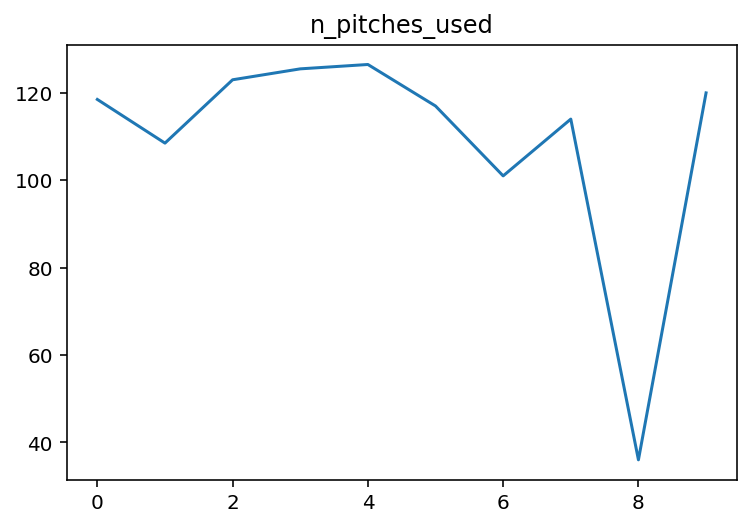

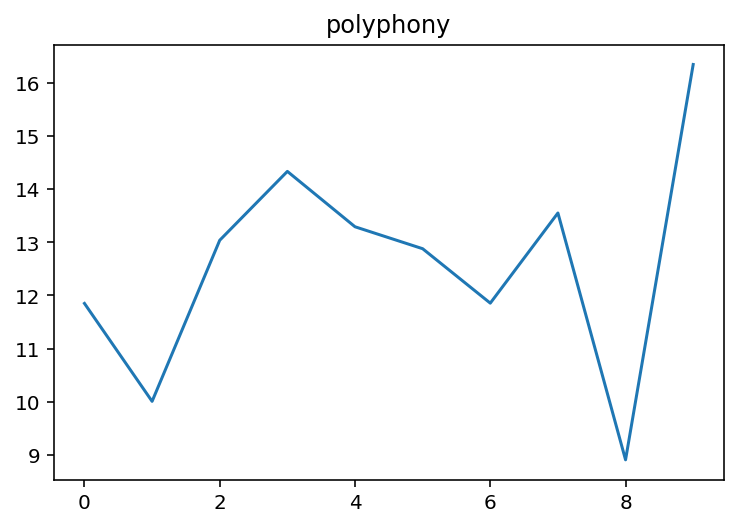

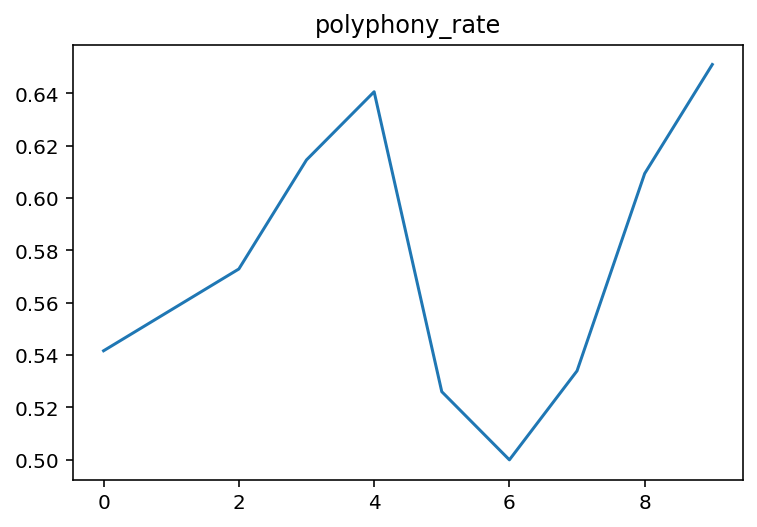

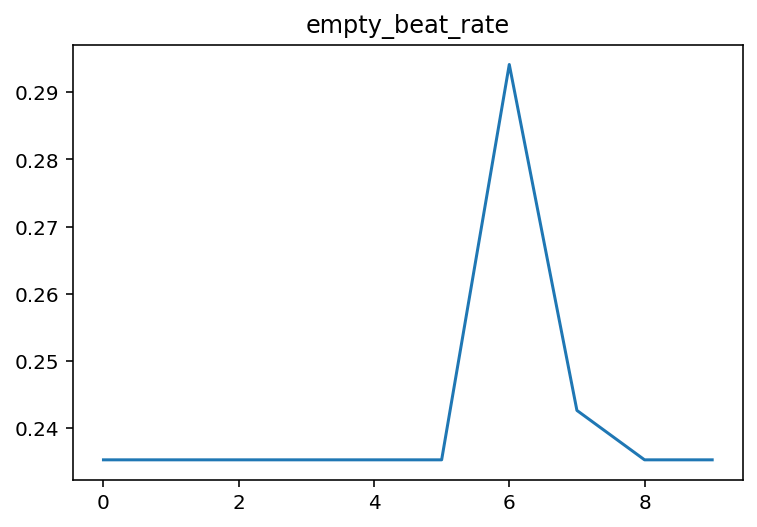

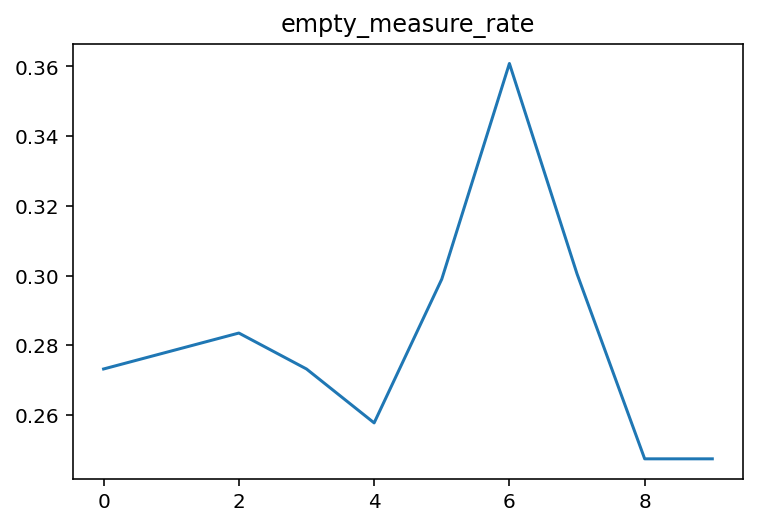

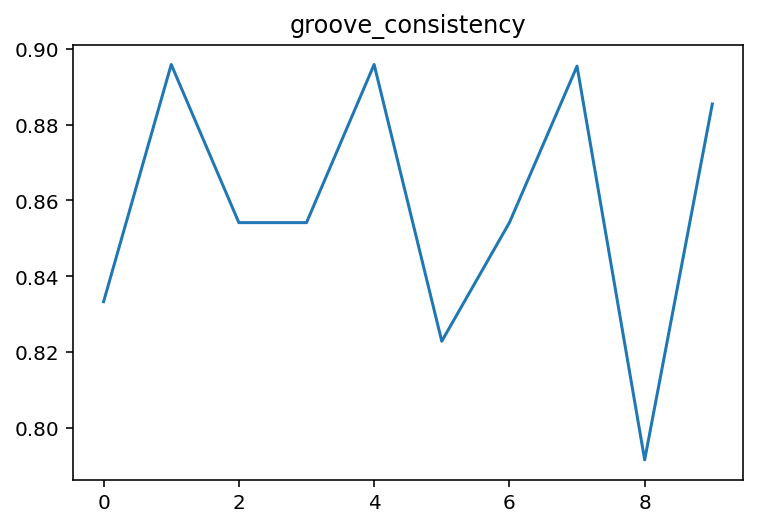

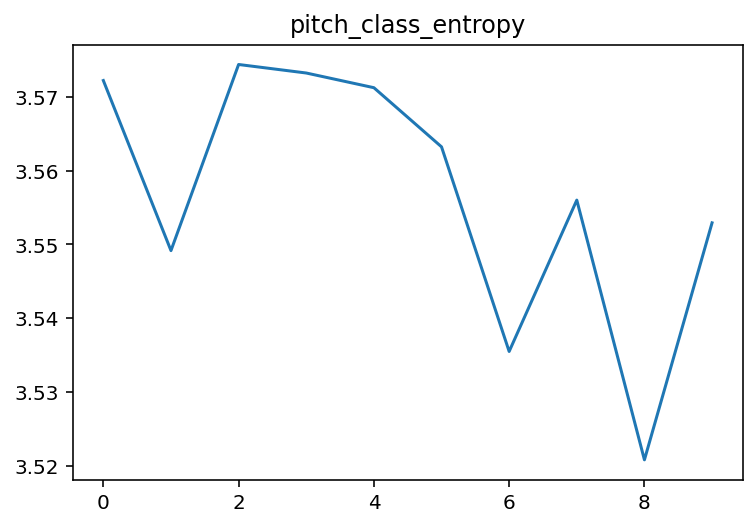

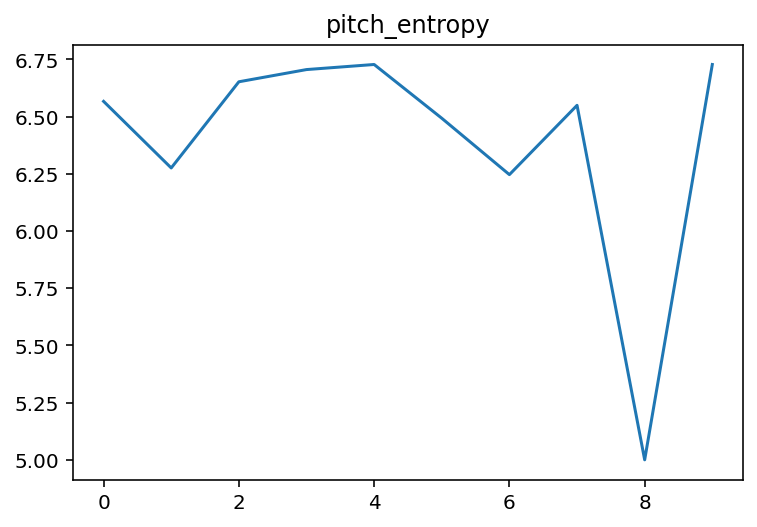

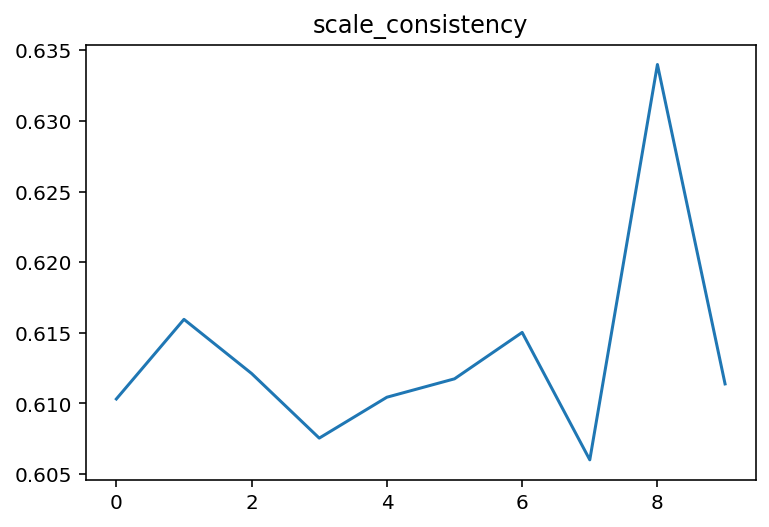

In [ ]:
for i in training_evaluation.columns:
    plt.figure()
    plt.title(i)
    plt.plot(training_evaluation[i])
# training_evaluation.plot()